In [415]:
import sys
import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid, trapezoid
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, SkyCoord, ICRS
from astropy.constants import c as c_light_speed
import astropy.units as u
import pystellibs
from numba import njit, prange
import numpy as np
from numpy.linalg import cholesky, solve

from yso_basel_comparison import flam_yso

In [2]:
sys.path.append('/Users/ratzenboe/Documents/work/projects/DomainAdapterSBI/dev_da/sed_basis/')
from kl_basis_learning import learn_instrument_aware_basis_sksvd, learn_kl_basis_sksvd
from rebin_spectrum import (make_uniform_log_grid, rebin_spectrum_flux_conserving,
                            normalize_kernel_dlog, rebin_batch_flux_conserving)

In [712]:
sys.path.append('dev/')
from dev.data import PhotData
from dev.evolution_tracks_parsec import EvoTrackPARSEC
from dev.base import PhotometryPipeline
from dev.dustmap_handler import DustMap
from dev.spectral_interpolator import SpectrumGenerator
from dev.photometry import Photometry
from dev.param_grid import make_representative_grid_lhs

parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot'
parsec_file_path = '/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv'
base_path_yso = '/Users/ratzenboe/Documents/work/data_local/spectal_models/yso_models/models_richardson24/'
dustmap_base_path = '/Users/ratzenboe/Documents/work/data_local/dustmap_data/'

In [4]:
@njit(parallel=True)
def batch_interp_numba(old_grid, new_grid, spectra):
    n_spec = spectra.shape[0]
    result = np.empty((n_spec, len(new_grid)))
    for i in prange(n_spec):
        result[i, :] = np.interp(new_grid, old_grid, spectra[i])
    return result

# Load field background data (Ribitzki et al. 2021)

In [5]:
fname_bg = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/field_1kpc_fundamentals_June2025.csv'
df_field = pd.read_csv(fname_bg)

In [6]:
np.random.seed(0)  # For reproducibility
n_field = 10_000

# Get random samples from field and cluster
idx_field = np.random.choice(df_field.shape[0], size=n_field, replace=False)
df_field_rs = df_field.loc[idx_field].reset_index(drop=True)

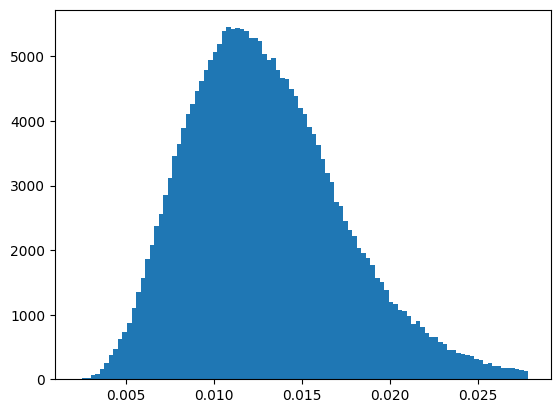

In [38]:
plt.hist(df_field['Z_metal'].values, bins=100);

In [44]:
df_field['logAge'].values.max()

10.0

# Create a combined DS

In [7]:
logT = df_field_rs['logT'].values  # Teff in Kelvin, 5772 K is the Sun's effective temperature
logL = df_field_rs['logL'].values
logg = df_field_rs['logg'].values  # Logarithm of surface gravity
Z_metal = df_field_rs['Z_metal'].values
mass = df_field_rs['mass'].values  # Current mass in solar masses
logAge = df_field_rs['logAge'].values  # Logarithm of age in years
Av_orig = df_field_rs['Av'].values  # Extinction in magnitudes

skycoords = SkyCoord(
    ra=df_field_rs['ra'].values * u.deg,
    dec=df_field_rs['dec'].values * u.deg,
    distance=1000 / df_field_rs['parallax'].values * u.pc,
    # pm_ra_cosdec=df['pmra'].values * u.mas / u.yr,
    # pm_dec=df['pmdec'].values * u.mas / u.yr,
    # radial_velocity=df['radial_velocity'].values * u.km / u.s,
    frame='icrs'
)

d_orig = skycoords.distance.to(u.pc).value  # Distance in parsecs

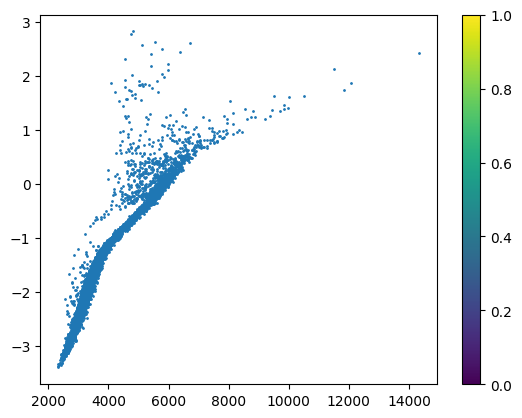

In [8]:
plt.scatter(10**logT, logL, s=1)
plt.colorbar()

# Create a PhotData object and set the parameters

In [9]:
# p_grid = make_representative_grid_lhs(10_000)
# m_ok = p_grid.mask_ms_ok

In [568]:
data = PhotData()
# data.logAge = p_grid.logAge[m_ok]
# data.Z = p_grid.Z[m_ok]
# data.mass = p_grid.M[m_ok]

data.logAge = logAge
data.Z = Z_metal
data.mass = mass
data.logT = logT
data.logg = logg
data.logL = logL
data.Av = Av_orig
data.skycoords = skycoords
data.Av = 0.
data.distance = 1000.0 * u.pc

In [713]:
phpipe = PhotometryPipeline(steps=[
    # ('evo_track', EvoTrackPARSEC(evo_track_path=parsec_file_path)),
    # ('disk_prop', CondDiskProperties()),
    # ('yso_model', YSO(base_dir=base_path_yso, yso_models='all')),
    ('spectrum', SpectrumGenerator(stellib=pystellibs.BTSettl())),
    # ('spectrum', SpectrumGenerator(stellib=pystellibs.BaSeL())),
    ('dustmap', DustMap(map_base_path=dustmap_base_path, dustmap_name='edenhofer')),
    # ('dustmap', DustMap(map_base_path=dustmap_base_path, dustmap_name='bayestar', mode='best')),
    # ('filter', Photometry(filter_names=["GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac']))
])

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


In [714]:
data = phpipe.run(data)
# data.aperture_arcsec = 3*np.ones(data.N) * u.arcsec

Generating spectra for 9982 sources (out of 10000)


Text(0.5, 1.0, 'mass: 0.7, logAge: 10.0, Z: 0.014, Teff: 4342, logL: -0.9, logg: 4.6')

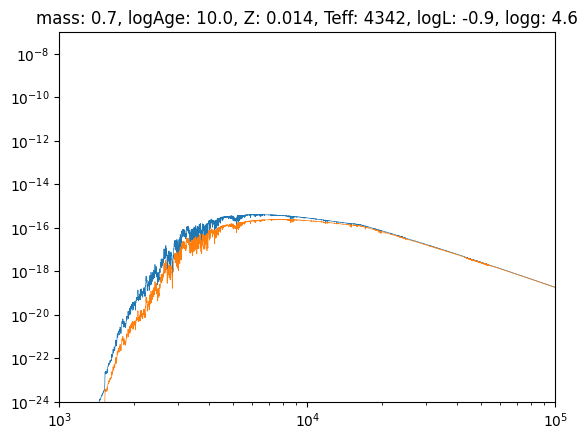

In [715]:
idx = 5
plt.loglog(data.wavelength.value, data.flam.value[idx], lw=0.5)
plt.loglog(data.wavelength.value, data.flam_dusty.value[idx], lw=0.5)
plt.ylim(1e-24, 1e-7)
plt.xlim(1000, 100000)
# plt.title(f'Av: {data.Av:.2f}  |  Av_orig: {Av_orig[idx]:.2f}')
plt.title(f'mass: {data.mass[idx]:.1f}, logAge: {data.logAge[idx]:.1f}, Z: {data.Z[idx]:.3f}, '
          f'Teff: {10**data.logT[idx]:.0f}, logL: {logL[idx]:.1f}, logg: {logg[idx]:.1f}')

In [716]:
flux_dusty = data.flam_dusty
flux = data.flam
wave = data.wavelength
# Compute the magnitudes
flux_bands = dict()
mag_band = dict()
cl_band = dict()
transmission_band = dict()

In [717]:
filter_step = PhotometryPipeline(steps=[
    ('filter', Photometry(filter_names=[
        "GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac', 'wise', 'PS1'
    ]))
])
data = filter_step.run(data)

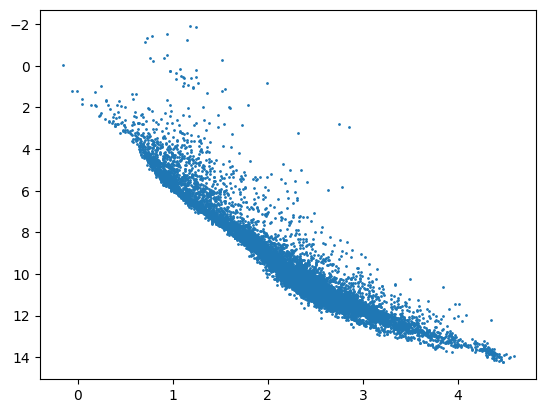

In [718]:
gaia_g = data.mag_band['GAIA_GAIA3.G']
gaia_bp = data.mag_band['GAIA_GAIA3.Gbp']
gaia_rp = data.mag_band['GAIA_GAIA3.Grp']
distance_pc = data.distance.to(u.pc).value
distance_modulus = 5 * np.log10(distance_pc) - 5
M_G = gaia_g.value - distance_modulus
plt.scatter(gaia_bp - gaia_rp, M_G, s=1)
plt.gca().invert_yaxis()

In [719]:
def get_zero_pt_flux(pb):
    # Compute the zero points
    if pb.name.split('_')[0] in ['GALEX', 'SDSS', 'PS1']:
        return pb.AB_zero_flux
    else:
        return pb.Vega_zero_flux

In [720]:
lam, lam_edges, w_log = make_uniform_log_grid(3000.0, 400_000.0, dlog=1/(3*2000))  # Å, Rmax≈5000

In [721]:
flux_rebinned = rebin_batch_flux_conserving(wave, flux, lam_edges)

In [728]:
flux_est = {}

for pb in filter_step.get_step('filter')._filter_bands:
    lam_filter_aa = pb.wavelength.to('AA').value
    transmit_filter = pb.transmit
    # rebin filter response on same wavelength grid
    k_raw = rebin_spectrum_flux_conserving(lam_filter_aa, transmit_filter, lam_edges)

    # # Compute photometry myself:
    # k = k_raw / np.sum(k_raw * w_log[0])
    #
    # # # ≈ ∫ k(λ) Fλ(λ) dlogλ
    # flux_in_band = np.sum(k * w_log[0] * flux_rebinned, axis=1)  # * u.erg / u.s / u.cm**2 / u.AA
    # flux_est[pb.name] = flux_in_band

    transmission_band[pb.name] = k_raw

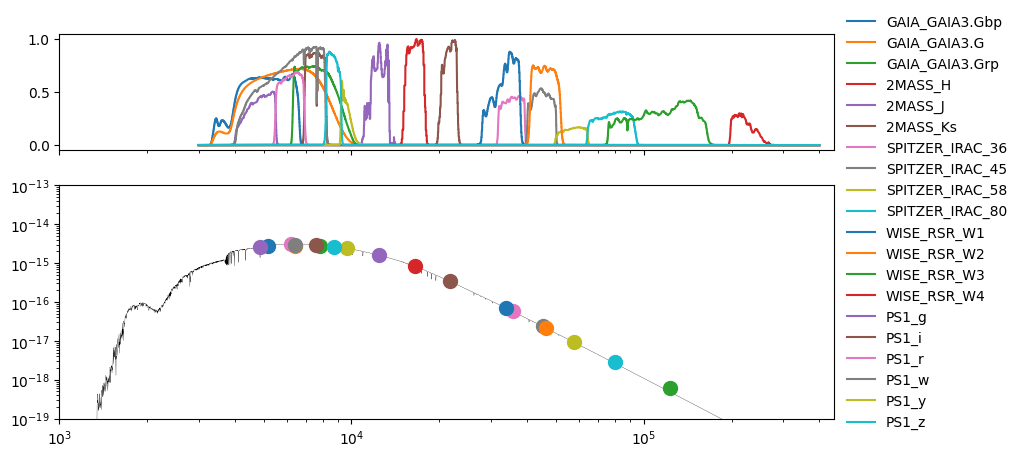

In [1128]:
idx = 9

fig, axes = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)

axes[1].loglog(wave, data.flam_dusty[idx], zorder=1, c='k', lw=0.2)
for band_name in data.flam_band.keys():
    # rebin filter response on same wavelength grid
    k_raw = transmission_band[band_name]
    axes[0].plot(lam, k_raw, label=band_name)
    axes[1].scatter(data.cl_band[band_name], data.flam_band[band_name][idx], s=100, zorder=10)
    # axes[1].scatter(data.cl_band[band_name], flux_est[band_name][idx], s=100, zorder=10, marker='x')
    # diff = (flux_est[band_name][idx] - data.flam_band[band_name][idx].value)/flux_est[band_name][idx]
    # if diff:
    #     print(diff)

axes[0].legend(frameon=False, loc='lower left', bbox_to_anchor=(1, -2.5))
axes[1].set_ylim(1e-19, 1e-13)

plt.xlim(1000, 450_000)
# plt.tight_layout()
plt.show()

# Learn instrument aware KL basis

In [730]:
# 0) Grid + measure
loglambda = np.log(lam)
# 0) Grid + measure
def norm_dlog(T):                          # normalize passband under dlogλ
    T = np.asarray(T, float)
    return T / (np.sum(T * w_log) + 1e-30)

# 1) Normalize passbands
bands = list(transmission_band.keys())
K_band = {b: norm_dlog(transmission_band[b]) for b in bands}

In [731]:
np.sum(K_band['GAIA_GAIA3.Gbp'] * w_log)

1.0000000000000002

In [732]:
train_frac = 0.9
idx_all = np.arange(flux_rebinned.shape[0])
idx_train = np.random.choice(idx_all, int(idx_all.size * 0.9))
idx_test = np.array(list(set(idx_all) - set(idx_train)))

In [751]:
data.mag_band['GAIA_GAIA3.G'].shape, idx_all.shape

((10000,), (10000,))

# SVD basis

In [733]:
basis_ms = learn_kl_basis_sksvd(
    simulated_seds=flux_rebinned[idx_train],
    lambda_grid=lam,
    n_components=128,
    variance_target=None,
    remove_gray_amplitude=True,
    n_iter=2,
    random_state=0
)

k (kl basis): 128, Xw.shape=(8986, 29358)


In [1178]:
def fit_band_priors_from_sims(basis, S_ref, K_bands_norm):
    """
    S_ref: (N,G) unextincted sims at 1 kpc, F_lambda on basis grid.
    Returns dict: band -> (beta (M+1,), sigma_alpha)
    """
    w = basis.w_log
    # project to shape coeffs (remove gray per sim using any band; here use true band flux)
    priors = {}
    # Precompute shape coeffs by dividing each SED by its *bolometric-ish* scale.
    # To stay band-agnostic, divide by median over G per spectrum (robust gray removal):
    scales = np.maximum(S_ref.mean(axis=1, keepdims=True), 1e-40).astype(np.float32)
    S_shape = S_ref / scales
    C = basis.project(S_shape)  # (N,M)

    for name, K in K_bands_norm.items():
        K = np.asarray(K, float)
        # α_r = ln F_r(1 kpc)
        F_r = (S_ref * (K[None, :] * w[None, :])).sum(axis=1)
        alpha_r = np.log(np.clip(F_r, 1e-50, None))
        X = np.hstack([np.ones((C.shape[0],1)), C])  # [1, c]
        beta, *_ = np.linalg.lstsq(X, alpha_r, rcond=None)
        resid = alpha_r - X @ beta
        sigma = float(np.std(resid))
        priors[name] = (beta, sigma)
    return priors

In [1179]:
row_keep = np.all(np.isfinite(flux_rebinned), axis=1)
priors = fit_band_priors_from_sims(basis_ms, flux_rebinned[row_keep], K_band)

In [1181]:
import numpy as np
from numpy.linalg import solve

# ========= Smoothness prior =========
def second_diff_matrix_loglam(loglam: np.ndarray) -> np.ndarray:
    """
    (G-2) x G second-difference operator on logλ (uniform dlogλ assumed).
    Approximates ∂²/∂(logλ)². Scaled by step^(-2).
    """
    G = loglam.size
    D2 = np.zeros((G-2, G), dtype=np.float64)
    h = float(np.median(np.gradient(loglam)))
    s = 1.0 / (h*h)
    for i in range(G-2):
        D2[i, i]   =  s
        D2[i, i+1] = -2*s
        D2[i, i+2] =  s
    return D2

def smoothness_precision_in_coeff_space(basis, eta: float) -> np.ndarray:
    """
    Return MxM matrix to add to the coeff precision:
        Prec_smooth = eta * Φ^T D2^T D2 Φ
    where D2 is the second-difference on logλ.
    """
    loglam = np.log(basis.lambda_grid.astype(np.float64))
    D2  = second_diff_matrix_loglam(loglam)        # (G-2, G)
    Phi = basis.phi.astype(np.float64)             # (G, M)
    LPhi = D2 @ Phi                                 # (G-2, M)
    return eta * (LPhi.T @ LPhi)                    # (M, M)

# ========= Band-aware amplitude prior (pivot bank) =========
def combine_amp_priors(prior_bank: dict, c: np.ndarray, bands_available: list[str]) -> tuple[float, float]:
    """
    prior_bank: {band: (beta(M+1,), sigma_alpha)}
    Returns pooled Gaussian prior α | c ~ N(mu_alpha, sigma_alpha^2)
    by precision pooling across available bands.
    """
    x = np.concatenate([[1.0], np.asarray(c, float)])
    prec_sum = 0.0
    mean_num = 0.0
    used = 0
    for b in bands_available:
        if b not in prior_bank:
            continue
        beta, sigma = prior_bank[b]
        mu = float(np.dot(beta, x))
        prec = 1.0 / (sigma**2 + 1e-30)
        mean_num += prec * mu
        prec_sum += prec
        used += 1
    if used == 0:
        return (0.0, 2.0)  # broad fallback
    mu_alpha = mean_num / prec_sum
    sigma_alpha = (1.0 / prec_sum) ** 0.5
    return mu_alpha, sigma_alpha

# ========= Band operator using already-normalized rows =========
def photo_operator_for_Av_with_K(basis, K_norm: np.ndarray, A_vec: np.ndarray):
    """
    K_norm: (R,G) rows ALREADY normalized under dlogλ (sum K*w = 1).
    A_vec:  (G,) attenuation at current Av on the basis grid.
    Returns band-space mean/basis: mu_f (R,), Phi_f (R,M).
    """
    w   = basis.w_log
    mu  = basis.mean_shape       # shape-only mean (from your pivot-free basis)
    Phi = basis.phi
    mu_f  = (K_norm * (A_vec[None, :] * w[None, :]) * mu[None, :]).sum(axis=1)  # (R,)
    Phi_f = K_norm @ (Phi * (A_vec * w)[:, None])                                # (R,M)
    return mu_f, Phi_f

# ========= Solver with smoothness + band-aware amp prior =========
def solve_map_c_and_alpha_with_smoothness(
    y: np.ndarray,                   # (R,) band fluxes (F_lambda band-avg)
    sigma: np.ndarray,               # (R,) band 1-sigmas (or diagonal equiv.)
    mu_f: np.ndarray,                # (R,)
    Phi_f: np.ndarray,               # (R,M)
    Prec_c_base: np.ndarray,         # (M,M) coeff prior precision (e.g., I for IA-KL)
    Prec_smooth: np.ndarray,         # (M,M) smoothness precision from above
    amp_prior_fn,                    # callable(c)->(mu_alpha, sigma_alpha)  from pivot bank
    prior_u: tuple[float,float] | None = None,  # distance prior on u=ln d: (mu_u, sigma_u)
    n_iter: int = 12,
    temper_amp_prior: float = 1.0,
) -> tuple[np.ndarray, float]:
    """
    Joint MAP for (c, α=ln a). The amplitude a combines distance and intrinsic scale.
    Adds: coefficient smoothness penalty and band-aware α|c prior.
    """
    y = np.asarray(y, float); sigma = np.asarray(sigma, float)
    R, M = Phi_f.shape
    W = np.diag(1.0 / np.clip(sigma, 1e-30, None)**2)

    S00 = float(mu_f @ (W @ mu_f))
    S01 = mu_f @ (W @ Phi_f)           # (M,)
    S11 = Phi_f.T @ (W @ Phi_f)        # (M,M)
    y0  = float(mu_f @ (W @ y))
    y1  = Phi_f.T @ (W @ y)            # (M,)

    Prec_c = Prec_c_base + Prec_smooth
    I = np.eye(M)

    c = np.zeros(M)
    # good α init from weighted ML amplitude with c=0
    t   = mu_f
    tWy = float(t @ (W @ y))
    tWt = float(t @ (W @ t))
    alpha = np.log(np.clip(tWy / (tWt + 1e-30), 1e-30, None))

    for _ in range(n_iter):
        a = np.exp(alpha)

        # c | α : (a^2 S11 + Prec_c) c = a (y1 - a S01)
        A = (a*a) * S11 + Prec_c
        b = a * (y1 - a * S01)
        c = solve(A, b)

        # reinit α at ML given updated c
        t   = mu_f + Phi_f @ c
        tWy = float(t @ (W @ y))
        tWt = float(t @ (W @ t))
        alpha = np.log(np.clip(tWy / (tWt + 1e-30), 1e-30, None))
        a = np.exp(alpha)

        # one Newton step including priors
        # data term (profiled) derivatives wrt α
        fp  = - tWy * a + tWt * a*a
        fpp = - tWy * a + 2.0 * tWt * a*a

        if prior_u is not None:  # distance prior u ~ N(mu_u, sigma_u^2), α = -2u
            mu_u, sig_u = prior_u
            fp  += (alpha + 2.0*mu_u) / (4.0*sig_u**2)
            fpp += 1.0 / (4.0*sig_u**2)

        if amp_prior_fn is not None:
            mu_a, sig_a = amp_prior_fn(c)
            sig_a_eff = temper_amp_prior * (sig_a + 1e-30)
            fp  += (alpha - mu_a) / (sig_a_eff**2)
            fpp += 1.0 / (sig_a_eff**2)

        step = np.clip(fp / np.clip(fpp, 1e-30, None), -2.0, 2.0)
        alpha -= step
        if abs(step) < 1e-7:
            break

    return c, float(np.exp(alpha))  # return coeffs and a = exp(alpha)

# ========= Full wrapper for a star (photometry-only example) =========

def reconstruct_star_from_photometry_with_smoothness(
    basis,
    obs_flux: dict,                # {band: (flux, sigma)} or scalar→ use frac_err
    K_bands_norm: dict,            # {band: (G,)} ALREADY dlog-normalized rows on basis grid
    atten_fn,                      # callable(lam, Av)-> A_vec on grid
    Av_grid: np.ndarray,           # grid to scan
    prior_bank: dict,              # pivot-bank {band: (beta(M+1,), sigma_alpha)}
    prior_u: tuple[float,float] | None,  # (mu_u, sigma_u) for ln d, or None
    prior_var_c: np.ndarray | float,     # (M,) or scalar; IA-KL → 1
    eta_smooth: float = 0.0,       # strength of smoothness penalty
    default_frac_err: float = 0.02,
    temper_amp_prior: float = 1.0
):
    lam = basis.lambda_grid; w = basis.w_log; Phi = basis.phi; mu = basis.mean_shape
    M = Phi.shape[1]

    # build band vectors (only those available)
    bands = []
    y_list, s_list = [], []
    rows = []
    for b, val in obs_flux.items():
        if b not in K_bands_norm:  # skip bands w/o kernel
            continue
        bands.append(b)
        rows.append(np.asarray(K_bands_norm[b], float))
        if np.isscalar(val):
            yb = float(val); sb = max(default_frac_err * abs(yb), 1e-30)
        else:
            yb, sb = float(val[0]), float(val[1])
        y_list.append(yb); s_list.append(sb)
    if not rows:
        raise ValueError("No overlapping bands between obs_flux and K_bands_norm.")
    K_norm = np.vstack(rows)                        # (R,G)
    y      = np.array(y_list, float)                # (R,)
    sigma  = np.array(s_list, float)                # (R,)
    R      = K_norm.shape[0]

    # coeff prior precision
    if np.isscalar(prior_var_c):
        Prec_c_base = (1.0/float(prior_var_c)) * np.eye(M)
    else:
        Prec_c_base = np.diag(1.0 / np.clip(np.asarray(prior_var_c, float), 1e-30, None))

    # smoothness precision (precompute once; independent of Av)
    Prec_smooth = smoothness_precision_in_coeff_space(basis, eta=eta_smooth) if eta_smooth > 0 else np.zeros((M,M))

    # band-aware amplitude prior function from the pivot bank
    def amp_prior_fn(c):
        return combine_amp_priors(prior_bank, c, bands)

    best = {"obj": np.inf}
    logw = []
    cands = []

    for Av in Av_grid:
        A = atten_fn(lam, Av)
        mu_f, Phi_f = photo_operator_for_Av_with_K(basis, K_norm, A)

        # solve for (c, a) with smoothness + amp prior
        c_map, a_map = solve_map_c_and_alpha_with_smoothness(
            y, sigma, mu_f, Phi_f,
            Prec_c_base=Prec_c_base,
            Prec_smooth=Prec_smooth,
            amp_prior_fn=amp_prior_fn,
            prior_u=prior_u,
            n_iter=12,
            temper_amp_prior=temper_amp_prior,
        )
        # predictions & objective
        y_pred = a_map * (mu_f + Phi_f @ c_map)
        res    = (y - y_pred) / np.clip(sigma, 1e-30, None)
        nll_data = 0.5 * np.sum(res**2)
        nll_c    = 0.5 * float(c_map @ (Prec_c_base @ c_map))  # base prior
        nll_s    = 0.5 * float(c_map @ (Prec_smooth @ c_map))  # smoothness penalty
        if prior_u is None:
            nll_u = 0.0
        else:
            mu_u, sig_u = prior_u
            u_hat = -0.5 * np.log(np.clip(a_map, 1e-30, None))
            nll_u = 0.5 * ((u_hat - mu_u)**2) / (sig_u**2 + 1e-30)
        mu_a, sig_a = amp_prior_fn(c_map)
        nll_a = 0.5 * ((np.log(a_map) - mu_a)**2) / ((temper_amp_prior*sig_a)**2 + 1e-30)

        obj = nll_data + nll_c + nll_s + nll_u + nll_a
        cands.append((Av, c_map, a_map, y_pred, obj))
        logw.append(-obj)

        if obj < best["obj"]:
            best = dict(Av=Av, c=c_map, a=a_map, y_pred=y_pred, obj=obj)

    # MAP reconstruction on the grid
    A_best = atten_fn(lam, best["Av"])
    s_hat  = best["a"] * A_best * (mu + Phi @ best["c"])
    d_hat  = 1.0 / np.sqrt(np.clip(best["a"], 1e-30, None))

    # optional Av-marginal mean
    logw = np.array(logw) - np.max(logw)
    wAv  = np.exp(logw); wAv /= wAv.sum()
    Av_m = float(np.sum(wAv * np.array([av for av, *_ in cands])))

    return {
        "used_bands": bands,
        "map": {
            "Av": float(best["Av"]),
            "d_kpc": float(d_hat),
            "a": float(best["a"]),
            "c": best["c"],
            "y_pred": best["y_pred"],
            "s_hat": s_hat,
        },
        "marginals": {"Av_mean": Av_m, "weights": wAv, "grid": Av_grid},
        "diagnostics": {
            "chi2": float(np.sum(((y - best["y_pred"]) / np.clip(sigma,1e-30,None))**2)),
            "R": int(R),
        }
    }

In [1142]:
priors['GAIA_GAIA3.Gbp'][0].shape

(129,)

# Instrument aware basis

In [734]:
basis_ms_ia = learn_instrument_aware_basis_sksvd(
    simulated_seds=flux_rebinned[idx_train],      # (N, G)
    lambda_grid=lam,        # (G,)
    rep_kernels=list(transmission_band.values()),   # list of (G,) (passbands or LSF windows), NOT normalized
    rep_sigmas=None,
    n_components=64,
    variance_target=None,
    remove_gray_amplitude=True,
    n_iter_svd=2,
    random_state=0,
)

n_components: 128
k (kl basis): 128, Xw.shape=(8986, 29358)
k: 19


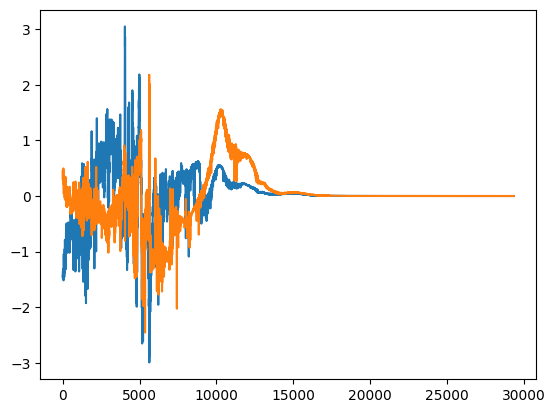

In [738]:
idx = 0
plt.plot(basis_ms.phi.T[idx])
plt.plot(basis_ms_ia.phi.T[idx])

# Apply to measurements

In [739]:
mu = basis_ms.mean_sed
phi = basis_ms.phi

def norm_dlog(T, w_log):
    """Row-normalize passbands under dlogλ so ∑ T_r,g w_g = 1."""
    Z = T @ w_log
    return T / (Z[:, None] + 1e-30)

# Given:
# lam (G,), w_log = Δlogλ (G,)
# K_band[b] (G,)  -- passband kernels normalized under dlogλ  (∑ K_band[b]*w_log = 1)
# mu (G,), phi (G,M)          -- IA-KL mean and modes (coeff prior ≈ I)
# attenuation_curve(lam, A_V) -- returns a(λ;A_V) array (G,)

# ---- 1) Precompute band rows (no extinction) ----
V0 = {b: (K_band[b] * w_log) @ phi for b in K_band}   # (M,) per band
y0 = {b: (K_band[b] * w_log) @ mu  for b in K_band}   # scalar per band

In [741]:
# V0['GAIA_GAIA3.Grp']
np.sum(K_band['GAIA_GAIA3.G'] * w_log)

0.9999999999999999

In [744]:
# Compute extincted spectrum
import extinction
law = extinction.fitzpatrick99
av_law = np.vectorize(extinction.fitzpatrick99, signature='(n),(),(),()->(n)')
Dlambda = np.exp(-1 * av_law(lam, 1.2, 3.1, unit='aa'))
if len(Dlambda[None, :].shape) == 1:
    # In case Av and Rv are scalars
    Dlambda = Dlambda[:, None]

def attenuation_fitzpatrick99(lambda_A, A_V, R_V=3.1):
    Dlambda = np.exp(-1 * av_law(lambda_A, A_V, R_V, unit='aa'))
    if len(Dlambda[None, :].shape) == 1:
        # In case Av and Rv are scalars
        Dlambda = Dlambda[:, None]
    return Dlambda

(0.0, 1.02)

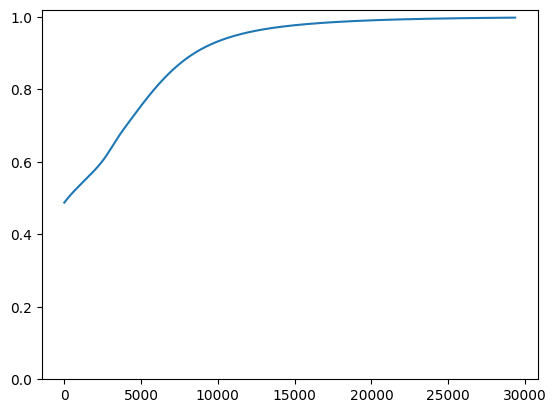

In [745]:
Av = 0.4
plt.plot(attenuation_fitzpatrick99(lam, Av))
plt.ylim(0, 1.02)

In [1054]:
# Build photometric operator for a given A_V:
# For each band r, compute:
#   mu_f[r]   = ∑_g μ_g * A_g(A_V) * T_r,g * w_g
#   Phi_f[r,:]= ∑_g φ_{g,:} * A_g(A_V) * T_r,g * w_g
def photo_operator_for_Av(basis, T_norm, A_vec):
    w = basis.w_log
    mu = basis.mean_sed
    Phi = basis.phi                 # (G, M)
    # W = (A_vec * w)[None, :]        # (1,G)
    mu_f  = (T_norm * (A_vec[None, :] * w[None, :]) * mu[None, :]).sum(axis=1)  # (R,)
    Phi_f = T_norm @ (Phi * (A_vec * w)[:, None])                                # (R,M)
    # mu_f (R,): the per-band mean flux you’d get from \mu(\lambda) after reddening
    # Phi_f (R, M): the per-band basis—how each KL mode contributes to each band after reddening
    # predicted band fluxes are y_{\text{pred}} = a (\mu_f + \Phi_f\,c\right)
    return mu_f, Phi_f

In [1066]:
# Given bands y (R,), σ (R,), and a fixed Av, solve MAP for c and a=exp(α) with a prior on ln d (u=ln d; α=-2u).
def solve_map_c_and_distance_for_Av(y, sigma, mu_f, Phi_f, prior_var_c, prior_u=None, ridge=1e-8):
    """Band-space MAP for c and a=exp(alpha) with optional Gaussian prior on u=ln d."""
    y = np.asarray(y, float); sigma = np.asarray(sigma, float)
    R, M = Phi_f.shape
    if sigma.ndim == 1:
        W = np.diag(1.0 / np.clip(sigma, 1e-30, None)**2)
    else:
        W = sigma  # assume already inverse covariance
    Prec_c = np.diag(1.0 / np.clip(prior_var_c, 1e-30, None))

    S00 = mu_f @ W @ mu_f
    S01 = mu_f @ W @ Phi_f          # (M,)
    S11 = Phi_f.T @ W @ Phi_f       # (M,M)
    y0  = mu_f @ W @ y
    y1  = Phi_f.T @ W @ y

    I = np.eye(M)
    c = np.zeros(M)
    alpha = 0.0  # ln a

    for _ in range(12):
        a = np.exp(alpha)
        # c update
        A = (a*a) * S11 + Prec_c + ridge * I
        b = a * (y1 - a * S01)
        c = solve(A, b)
        # alpha update (Newton)
        tWy = y0 + c @ y1
        tWt = S00 + 2.0*(S01 @ c) + c @ (S11 @ c)
        fp  = - tWy * np.exp(alpha) + tWt * np.exp(2*alpha)
        fpp = - tWy * np.exp(alpha) + 2.0 * tWt * np.exp(2*alpha)
        if prior_u is not None:  # u ~ N(mu_u, sigma_u^2), alpha=-2u
            mu_u, sig_u = prior_u
            fp  += (alpha/4.0 + mu_u/2.0) / (sig_u**2)
            fpp += 1.0 / (4.0 * sig_u**2)
        step = np.clip(fp / np.clip(fpp, 1e-30, None), -2.0, 2.0)
        alpha -= step
        if abs(step) < 1e-7: break

    return c, float(np.exp(alpha))

def prior_u_from_parallax(pi_obs_mas, sig_pi_mas):
    """Gaussian prior on u=ln d[kpc] via delta method; good when SNR is decent (π>0)."""
    if pi_obs_mas <= 0 or sig_pi_mas <= 0:
        return (0.0, 2.0)  # very broad
    mu_u = -np.log(pi_obs_mas) + 0.5 * (sig_pi_mas/pi_obs_mas)**2
    sig_u = (sig_pi_mas/pi_obs_mas)
    return (float(mu_u), float(sig_u))

def reconstruct_sed_from_photometry_obs(
    basis,
    obs_flux: dict,               # {band: flux} or {band: (flux, sigma)}
    passbands: dict,              # {band: T_raw_on_grid (G,)}  (sampled on basis.lambda_grid)
    Av_grid: np.ndarray,          # e.g. np.linspace(0,3,31)
    parallax: tuple | None,       # (pi_obs_mas, sigma_pi_mas) or None
    prior_u: tuple | None = None, # (mu_u, sigma_u) for ln d; overrides parallax if given
    prior_var_c: np.ndarray | None = None,  # (M,) diag; default = ones (IA-whitened) or basis.evals
    default_frac_err: float = 0.02
):
    """
    Returns dict with MAP and (optionally) Av-marginal reconstructions.
    Interprets obs_flux values: if scalar → sigma = default_frac_err * flux.
    """
    lam = basis.lambda_grid
    w_log = basis.w_log
    Phi = basis.phi
    mu = basis.mean_sed
    M = Phi.shape[1]
    # gather common bands, build y, sigma, and T_norm
    rows = []; y_list = []; s_list = []; used_bands = []
    for b, val in obs_flux.items():
        if b not in passbands: continue
        T_row = np.asarray(passbands[b], float)  # already on lam
        rows.append(T_row)
        if np.isscalar(val):
            flux = float(val)
            sigma = max(default_frac_err * abs(flux), 1e-30)
        else:
            flux, sigma = float(val[0]), float(val[1])
        y_list.append(flux)
        s_list.append(sigma)
        used_bands.append(b)
    if not rows:
        raise ValueError("No overlap between obs bands and passbands.")
    T_norm = np.array(rows, float)
    y = np.array(y_list, float)
    sigma = np.array(s_list, float)
    R = T_norm.shape[0]

    # c prior
    if prior_var_c is None:
        prior_var_c = np.ones(M) if (np.isscalar(getattr(basis, "evals", 1.0))) else np.asarray(basis.evals, float)
        prior_var_c = np.clip(prior_var_c, 1e-6, None)

    # distance prior from parallax if provided
    if prior_u is None and parallax is not None:
        prior_u = prior_u_from_parallax(*parallax)

    # grid over Av
    best = {"obj": np.inf}
    log_weights = []
    cand = []
    for Av in Av_grid:
        A = attenuation_fitzpatrick99(lam, Av)
        mu_f, Phi_f = photo_operator_for_Av(basis, T_norm, A)  # (R,), (R,M)
        c_map, a_map = solve_map_c_and_distance_for_Av(y, sigma, mu_f, Phi_f,
                                                       prior_var_c=prior_var_c, prior_u=prior_u, ridge=1e-8)
        y_pred = a_map * (mu_f + Phi_f @ c_map)
        # objective = data NLL + c-prior + u-prior
        res = (y - y_pred) / np.clip(sigma, 1e-30, None)
        nll_data = 0.5 * np.sum(res**2)
        nll_c    = 0.5 * np.sum((c_map**2) / np.clip(prior_var_c, 1e-30, None))
        if prior_u is None:
            nll_u = 0.0
        else:
            mu_u, sig_u = prior_u
            u_hat = -0.5 * np.log(np.clip(a_map, 1e-30, None))
            nll_u = 0.5 * ((u_hat - mu_u)**2) / (sig_u**2)
        obj = nll_data + nll_c + nll_u
        cand.append((Av, c_map, a_map, y_pred, obj))
        log_weights.append(-obj)

        if obj < best["obj"]:
            best = dict(Av=Av, c=c_map, a=a_map, y_pred=y_pred, obj=obj)

    # MAP reconstruction on full grid
    A_best = attenuation_fitzpatrick99(lam, best["Av"])
    s_hat  = best["a"] * A_best * (mu + Phi @ best["c"])
    d_hat  = 1.0 / np.sqrt(np.clip(best["a"], 1e-30, None))

    # simple Av marginal (optional): normalized exp(-obj)
    logw = np.array(log_weights) - np.max(log_weights)
    w = np.exp(logw); w /= w.sum()
    Av_marg = np.sum(w * np.array([av for av, *_ in cand]))
    # (you can also form a weighted mean SED if desired)

    return {
        "used_bands": used_bands,
        "map": {
            "Av": float(best["Av"]),
            "d_kpc": float(d_hat),
            "a": float(best["a"]),
            "c": best["c"],
            "y_pred": best["y_pred"],
            "s_hat": s_hat
        },
        "marginals": {
            "Av_mean": float(Av_marg),
            "weights": w,
            "grid": Av_grid
        },
        "diagnostics": {
            "chi2": float(np.sum(((y - best["y_pred"]) / np.clip(sigma,1e-30,None))**2)),
            "R": int(R)
        }
    }

In [1102]:
def check_rows_normalized(K, w_log, tol=1e-8):
    """Return max|sum_r K*w - 1| to verify dlogλ normalization."""
    rowsum = K @ w_log
    return float(np.max(np.abs(rowsum - 1.0)))

def photo_operator_for_Av_with_K(basis, K_norm, A_vec):
    """
    Build band-space operator for a given extinction A(λ) when passbands are
    ALREADY normalized under dlogλ. (R,G) K_norm, (G,) A_vec.
    Returns: mu_f (R,), Phi_f (R,M).
    """
    w = basis.w_log
    mu = basis.mean_sed
    Phi= basis.phi  # (G,M)
    # y = sum_g K_r,g * [ A_g * s_g ] * w_g
    mu_f  = (K_norm * (A_vec[None, :] * w[None, :]) * mu[None, :]).sum(axis=1)   # (R,)
    Phi_f = K_norm @ (Phi * (A_vec * w)[:, None])                                 # (R,M)
    return mu_f, Phi_f

def fit_c_and_amplitude_on_grid(s_target, basis, sigma=None, ridge=1e-8, iters=10):
    """
    Fit c and gray amplitude a on the full wavelength grid (no extinction),
    minimizing || s_target - a(μ+Φc) ||_W with W = diag(w_log/σ^2) (or w_log if σ None).
    Returns (c_hat, a_hat).
    """
    mu, Phi, w = basis.mean_sed, basis.phi, basis.w_log
    G, M = w.size, Phi.shape[1]
    if sigma is None:
        wpix = w.copy()
    else:
        sig2 = np.asarray(sigma, float)**2
        if sig2.shape != (G,): raise ValueError("sigma must be (G,) on the grid")
        wpix = w / np.clip(sig2, 1e-30, None)

    # precompute Φ^T W Φ and Φ^T W μ, μ^T W μ, Φ^T W s, μ^T W s
    PhiT_W_Phi = np.einsum('g,gj,gk->jk', wpix, Phi, Phi, optimize=True)      # (M,M)
    PhiT_W_mu  = np.einsum('g,gj,g->j',  wpix, Phi, mu, optimize=True)        # (M,)
    muT_W_mu   = float(np.dot(wpix * mu, mu))                                 # scalar
    PhiT_W_s   = np.einsum('g,gj,g->j',  wpix, Phi, s_target, optimize=True)  # (M,)
    muT_W_s    = float(np.dot(wpix * mu, s_target))                           # scalar

    c = np.zeros(Phi.shape[1], float)
    # init a from regressing s on μ
    a = muT_W_s / (muT_W_mu + 1e-30)

    I = np.eye(Phi.shape[1])
    for _ in range(iters):
        # update c | a: (a^2 Φ^T W Φ + ridge I)c = a(Φ^T W s - a Φ^T W μ)
        A = (a*a) * PhiT_W_Phi + ridge * I
        b = a * (PhiT_W_s - a * PhiT_W_mu)
        c = solve(A, b)
        # update a | c (closed-form): a = (t^T W s) / (t^T W t), t=μ+Φc
        t    = mu + Phi @ c
        tWs  = float(np.dot(wpix * t, s_target))
        tWt  = float(np.dot(wpix * t, t))
        a    = tWs / (tWt + 1e-30)

    return c, float(a)


def debug_photometry_projection_with_user_inputs(
    basis,
    K_bands,                 # dict: {band_name: K_row_on_grid}, each row ALREADY normalized under dlogλ
    bands_to_use,            # list of band_names to use in this check
    Av_true, d_true,         # scalars
    atten_fn,                # callable: atten_fn(lambda_grid, Av_true) -> A_vec (G,)
    s_unatten=None,          # optional (G,) flux at Earth WITHOUT extinction; if provided, used to get (c_true,a_true)
    sigma_grid=None,         # optional (G,) per-pixel σ for the (c,a) fit from s_unatten
    noise_frac=0.0,          # optional fractional band noise for the optional recovery test
    rng=0,
    do_recover_from_bands=True
):
    """
    Uses your Fitzpatrick atten_fn and your normalized passbands to verify:
    - K row normalization
    - grid projection == band-space projection at true (Av,d)
    - Jacobian dy/dc
    - (optional) recover c from bands and compare to c_true (if s_unatten given)
    """
    rng = np.random.default_rng(rng)
    lam = basis.lambda_grid; w = basis.w_log; mu = basis.mean_sed; Phi = basis.phi
    M = Phi.shape[1]

    # 1) Stack requested bands
    rows = []
    used = []
    for b in bands_to_use:
        if b not in K_bands:
            raise KeyError(f"Band '{b}' not in K_bands.")
        row = np.asarray(K_bands[b], float)
        if row.shape != lam.shape:
            raise ValueError(f"Band '{b}' row has shape {row.shape}, expected {lam.shape}.")
        rows.append(row); used.append(b)
    K_norm = np.vstack(rows)              # (R,G)
    R = K_norm.shape[0]

    # 2) Check normalization under dlogλ
    row_err = check_rows_normalized(K_norm, w)

    # 3) Get c_true, a_true (unattenuated fit) if s_unatten provided; else draw a small random c_true
    if s_unatten is not None:
        c_true, a_unatt = fit_c_and_amplitude_on_grid(s_unatten, basis, sigma=sigma_grid, ridge=1e-8, iters=12)
        # with distance known, the expected attenuated scale is a_true = (1/d^2),
        # but s_unatten might already include distance; we will override scale below with d_true.
    else:
        c_true = rng.normal(0.0, 0.5, size=M)
        a_unatt = 1.0

    # 4) True attenuation and scale at Earth
    A = atten_fn(lam, Av_true)               # (G,)
    a_true = 1.0 / (d_true**2)               # geometric scale
    s_shape = mu + Phi @ c_true              # shape-only
    s_earth = a_true * A * s_shape           # truth at Earth

    # 5) Band flux via grid projection
    y_grid = K_norm @ (s_earth * w)          # (R,)

    # 6) Band-space operator and prediction via μ,Φ
    mu_f, Phi_f = photo_operator_for_Av_with_K(basis, K_norm, A)
    y_basis = a_true * (mu_f + Phi_f @ c_true)

    # 7) Compare projections
    abs_err = np.abs(y_grid - y_basis)
    rel_err = abs_err / np.clip(np.maximum(np.abs(y_grid), np.abs(y_basis)), 1e-30, None)
    max_rel = float(rel_err.max()); rms_rel = float(np.sqrt(np.mean(rel_err**2)))

    # 8) Jacobian check: ∂y/∂c_m ≈ a_true * Phi_f[:,m]
    eps = 1e-5
    J_fd = np.zeros((R, M))
    for m in range(M):
        cp = c_true.copy(); cm = c_true.copy()
        cp[m] += eps; cm[m] -= eps
        y_plus  = K_norm @ ( (a_true * A * (mu + Phi @ cp)) * w )
        y_minus = K_norm @ ( (a_true * A * (mu + Phi @ cm)) * w )
        J_fd[:, m] = (y_plus - y_minus) / (2*eps)
    J_model = a_true * Phi_f
    jac_rel = np.abs(J_fd - J_model) / np.clip(np.maximum(np.abs(J_fd), np.abs(J_model)), 1e-30, None)
    jac_max = float(jac_rel.max()); jac_rms = float(np.sqrt(np.mean(jac_rel**2)))

    # 9) (Optional) Recover c from bands with Av,d fixed and compare to c_true
    recovery = {}
    if do_recover_from_bands:
        y_obs = y_grid.copy()
        if noise_frac > 0:
            sig_b = noise_frac * np.maximum(np.abs(y_obs), 1e-30)
            y_obs = y_obs + rng.normal(0.0, sig_b)
            W = np.diag(1.0 / np.clip(sig_b, 1e-30, None)**2)
        else:
            W = np.eye(R)

        # Prior on c: IA-KL is typically whitened → I
        Prec = np.eye(M)
        S11 = Phi_f.T @ W @ Phi_f
        S01 = mu_f @ W @ Phi_f
        y1  = Phi_f.T @ W @ y_obs
        # solve (a^2 S11 + Prec) c = a (y1 - a S01)
        A_sys = (a_true**2) * S11 + Prec
        b_sys = a_true * (y1 - a_true * S01)
        c_rec = solve(A_sys, b_sys)
        recovery = {
            "c_rec": c_rec,
            "rms_coeff_error": float(np.sqrt(np.mean((c_rec - c_true)**2)))
        }

    # 10) Print quick summary
    print(f"[K rows] max |Σ K*w - 1| = {row_err:.3e}")
    print(f"[Proj]  max rel err = {max_rel:.3e} ; RMS rel err = {rms_rel:.3e}")
    print(f"[Jac]   max rel err = {jac_max:.3e} ; RMS rel err = {jac_rms:.3e}")
    if recovery:
        print(f"[Recover c] RMS coeff err = {recovery['rms_coeff_error']:.3e}  (R={R}, M={M})")

    return {
        "bands_used": used,
        "row_norm_max_err": row_err,
        "proj": {"max_rel_err": max_rel, "rms_rel_err": rms_rel, "y_grid": y_grid, "y_basis": y_basis},
        "jacobian": {"max_rel_err": jac_max, "rms_rel_err": jac_rms},
        "recovery": recovery,
        "truth": {"c_true": c_true, "a_true": a_true, "d_true": d_true, "Av_true": Av_true},
        "K_stack": K_norm
    }

In [1109]:
# Get random star from test set
idx = 1
plx = 1000./data.distance.value
Av_tst = data.Av[idx_test[idx]]
flam_dusty_tst = data.flam_dusty[idx_test[idx]]
flam_real = flux_rebinned[idx_test[idx]]
band_flam_tst = {key: data.flam_band[key][idx_test[idx]] for key in K_band.keys()}
band_cl_tst = {key: data.cl_band[key] for key in K_band.keys()}

In [1091]:
plx_err = 0.1
Av_err = 0.2
flam_band_err_perc = 0.1
# Simulate observation
plx_obs = plx + np.random.normal(loc=0, scale=plx_err, size=1)[0]
band_flam_obs = {key: val.value + np.random.normal(loc=0, scale=val.value*flam_band_err_perc) for key, val in band_flam_tst.items()}
sigma_flam = {key: val.value*flam_band_err_perc for key, val in band_flam_tst.items()}

(1e-26, 1e-16)

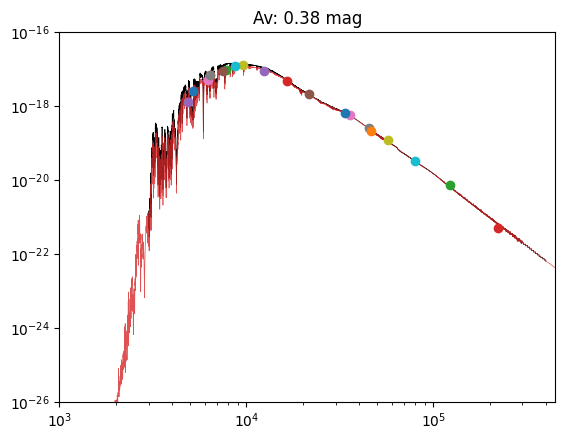

In [1111]:
plt.loglog(lam, flam_real, c='k', lw=0.5)
plt.loglog(wave, flam_dusty_tst, lw=0.5, c='tab:red', alpha=0.8)

for b in band_flam_obs.keys():
    plt.scatter(band_cl_tst[b], band_flam_obs[b], zorder=10)

plt.title(f"Av: {Av_tst:.2f} mag")
plt.xlim(1000, 450_000)
plt.ylim(1e-26, 1e-16)

In [1112]:
Av_est = 0.3
prior_u = prior_u_from_parallax(plx_obs, plx_err)
T_norm = np.asarray([K_band[b] for b in bands])
A_vec = attenuation_fitzpatrick99(lam, Av_est)
# photo_operator_for_Av(basis_ms, )
basis = basis_ms_ia
mu_f, Phi_f = photo_operator_for_Av(basis, T_norm, A_vec)

In [1113]:
# y = np.asarray([band_flam_obs[b] for b in bands])
# sigma = np.asarray([sigma_flam[b] for b in bands])

In [1114]:
flam_real.shape

(29358,)

In [1115]:
out = debug_photometry_projection_with_user_inputs(
    basis=basis,
    K_bands=K_band,
    bands_to_use=bands,  # any subset
    Av_true=Av_tst,
    d_true=1.0,                      # kpc
    atten_fn=attenuation_fitzpatrick99,
    s_unatten=flam_real,             # optional; improves the “true c” reference
    sigma_grid=None,                 # per-pixel σ if you want to weight that fit
    noise_frac=0.1,                  # optional noise for the recovery test
    rng=0
)

[K rows] max |Σ K*w - 1| = 1.071e-08
[Proj]  max rel err = 6.431e-16 ; RMS rel err = 2.796e-16
[Jac]   max rel err = 2.808e-08 ; RMS rel err = 2.356e-09
[Recover c] RMS coeff err = 1.695e-01  (R=20, M=19)


In [1125]:
out['truth']

{'c_true': array([-8.59420482e-28, -2.12776703e-29, -1.27168688e-28, -1.66993853e-28,
        -9.53855379e-30,  5.47393468e-29, -7.43483212e-30, -2.77106178e-30,
        -1.48080850e-29, -1.01338928e-29,  6.22390501e-30,  3.52140290e-29,
         3.41467283e-30, -2.50824242e-29,  5.39770417e-30,  2.13522137e-29,
        -2.41899817e-30, -9.41127207e-30,  3.20466418e-29]),
 'a_true': 1.0,
 'd_true': 1.0,
 'Av_true': 0.3842705747463745}

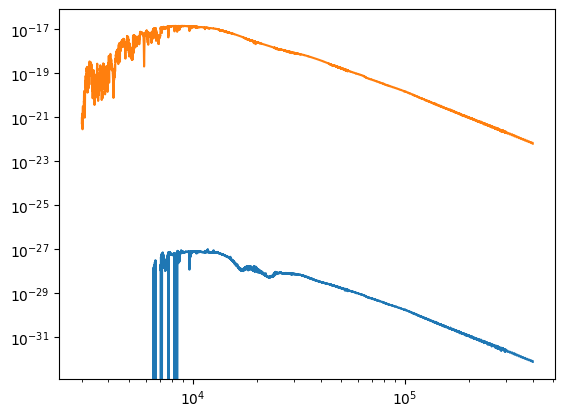

In [1124]:
plt.loglog(lam, basis.phi @ out['truth']['c_true'])
plt.loglog(lam, flam_real);

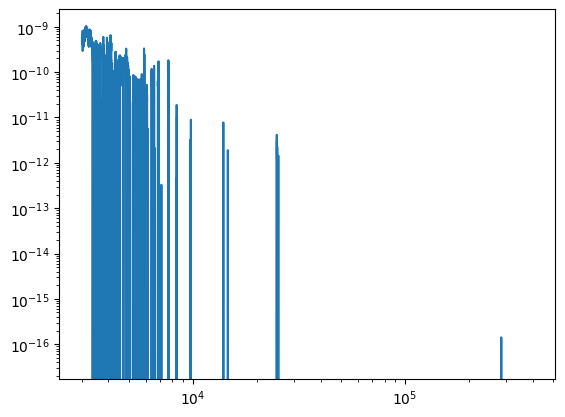

In [ ]:
# Given bands y (R,), σ (R,), and a fixed Av, solve MAP for c and a=exp(α) with a prior on ln d (u=ln d; α=-2u).
def solve_map_c_and_distance_for_Av(y, sigma, mu_f, Phi_f, prior_var_c, prior_u=None, ridge=1e-8, newton_steps=3):
    R, M = Phi_f.shape
    W = np.diag(1.0 / np.clip(sigma, 1e-30, None)**2) if sigma.ndim == 1 else sigma
    # Diagonal prior on c
    Prec_c = np.diag(1.0 / np.clip(prior_var_c, 1e-30, None))
    # Precompute S matrices in band space
    S00 = mu_f @ W @ mu_f
    S01 = mu_f @ W @ Phi_f          # (M,)
    S11 = Phi_f.T @ W @ Phi_f       # (M,M)
    y0  = mu_f @ W @ y
    y1  = Phi_f.T @ W @ y
    # Initialize
    c = np.zeros(M)
    alpha = 0.0  # ln a
    I = np.eye(M)
    for _ in range(10):
        a = np.exp(alpha)
        # c update: (a^2 S11 + Prec_c + ridge I) c = a (y1 - a S01)
        A = (a*a) * S11 + Prec_c + ridge * I
        b = a * (y1 - a * S01)
        c = solve(A, b)
        # alpha (ln a) update (Newton), including prior on u=ln d if provided
        tWy = y0 + c @ y1
        tWt = S00 + 2.0 * (S01 @ c) + c @ (S11 @ c)
        # data gradient/curvature
        fp  = - tWy * np.exp(alpha) + tWt * np.exp(2*alpha)
        fpp = - tWy * np.exp(alpha) + 2.0 * tWt * np.exp(2*alpha)
        # prior on u = ln d: u ~ N(mu_u, sigma_u^2), α = ln a = -2u
        if prior_u is not None:
            mu_u, sig_u = prior_u
            # add derivative of 0.5*((u-mu_u)^2/σ^2) wrt α
            fp  += (alpha/4.0 + mu_u/2.0) / (sig_u**2)
            fpp += 1.0 / (4.0 * sig_u**2)
        step = np.clip(fp / np.clip(fpp, 1e-30, None), -2.0, 2.0)
        alpha -= step
        # small loop of Newton steps
        for _ in range(newton_steps-1):
            a = np.exp(alpha)
            fp  = - tWy * a + tWt * a*a
            fpp = - tWy * a + 2.0 * tWt * a*a
            if prior_u is not None:
                fp  += (alpha/4.0 + mu_u/2.0) / (sig_u**2)
                fpp += 1.0 / (4.0 * sig_u**2)
            step = np.clip(fp / np.clip(fpp, 1e-30, None), -2.0, 2.0)
            alpha -= step
        if abs(step) < 1e-7:
            break
    a_map = np.exp(alpha)
    return c, a_map

In [45]:
def attenuation_curve(lam, Av):
    Dlambda = np.exp(-1 * av_law(lam, Av, 3.1, unit='aa'))
    return Dlambda


# ---- 2) Per-star encoding with A_V marginalization (grid) ----
def encode_star_with_Av(y_obs, sig_obs, bands_obs, Av_grid, prior_logpdf):
    """
    y_obs: dict band->flux, sig_obs: dict band->sigma
    bands_obs: list of bands available for this star
    Av_grid: array of trial A_V values
    prior_logpdf: function log p(A_V)
    Returns: c_mean (M,), c_cov (M,M) marginalized over A_V, plus posterior over A_V
    """
    y   = np.array([y_obs[b]   for b in bands_obs])
    sig = np.array([sig_obs[b] for b in bands_obs])
    W   = 1.0 / (sig**2 + 1e-30)
    M   = phi.shape[1]

    log_like = []
    c_list, S_inv_list = [], []

    for Av in Av_grid:
        a = attenuation_curve(lam, Av)            # (G,)
        # NOTE: do NOT renormalize passbands after applying 'a'
        V = np.stack([((K_band[b] * w_log) @ (a[:,None] * phi))   for b in bands_obs], axis=0)  # (Nobs,M)
        ybar = np.array([((K_band[b] * w_log) @ (a * mu))         for b in bands_obs])          # (Nobs,)

        # Gaussian linear solve with IA-KL prior ≈ I
        A = V.T * W @ V + np.eye(M)
        b = V.T * W @ (y - ybar)

        L = np.linalg.cholesky(A)
        c_hat = np.linalg.solve(L.T, np.linalg.solve(L, b))
        # Posterior covariance in c
        Ainv = np.linalg.solve(L, np.eye(M))
        Sigma_c = Ainv @ Ainv.T

        # Log-evidence (marginal likelihood), up to const:
        quad = (y - ybar) @ (W * (y - ybar))
        logdetA = 2.0 * np.sum(np.log(np.diag(L)))
        logp_y_given_Av = -0.5 * (quad - c_hat @ (A @ c_hat) + logdetA)  # (KL prior is I)

        log_like.append(logp_y_given_Av + prior_logpdf(Av))
        c_list.append(c_hat)
        S_inv_list.append(Sigma_c)

    # Normalize weights
    log_like = np.array(log_like)
    w = np.exp(log_like - log_like.max())
    w /= w.sum() + 1e-30

    # Mixture mean & covariance over A_V
    c_mean = np.sum(w[:,None] * np.stack(c_list), axis=0)
    # law of total covariance
    cov_terms = [S_inv_list[j] + np.outer(c_list[j], c_list[j]) for j in range(len(Av_grid))]
    C = np.sum(w[j] * cov_terms[j] for j in range(len(Av_grid))) - np.outer(c_mean, c_mean)

    Av_post = {"grid": Av_grid, "weights": w}
    return c_mean, C, Av_post

# ---- 3) (Optional) gray amplitude (distance) column ----
# If you didn’t normalize out amplitude, add a column of ones to V and put a prior on it:
#   Z = np.ones((Nobs,1)); tau_A2 = prior_var_from_distance
#   augment A and b with Z as in earlier messages (block normal equations),
#   or normalize your observed fluxes to a reference band to remove it exactly.

In [ ]:

encode_star_with_Av(y_obs, sig_obs, bands_obs, Av_grid, prior_logpdf)